In [568]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from numpy.random import rand
from scipy.stats import truncexpon

In [569]:
#######################################################################################################
########################################## USEFULL FUNCTIONS ##########################################
#######################################################################################################

### k-E relations ###
k2E = lambda k:81.8*(k/(2*np.pi))**2
E2k = lambda E:2*np.pi*np.sqrt(E/81.8)

### Q-theta relations ###
theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))
Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))

##### dQ-dtheta relation #####
def dqdtheta(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))

def dthetadq(omega, ki, Q):
    a = ki**2*(2-omega/k2E(ki))
    b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
    return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))


########################################################################################################
####################################### LINE-SOLID INTERCEPTIONS #######################################
########################################################################################################

############### Line parametrization ###############
def line_param(t, p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
    return np.array([p[:,0] + v[:,0]*t, p[:,1] + v[:,1]*t, p[:,2] + v[:,2]*t]).T


############### CYLINDER ###############

### Line-cylinder intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def CylLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    t1c, t2c = (-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)

    return np.sort((t1c, t2c), axis=0).T

### Line-cylinder intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def CylLine_inter_fromin(geom, p, v):
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinder
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    tc = np.max([(-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)], axis=0) # take the higher t, that is the only one positive solution!

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0) # take the higher t, that is the only one positive solution!
    
    return np.sort((tc, tz), axis=0)[0].T


############### CUBOID ###############

### Line-cuboid intersection with p0 outside ###
def CubLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the x walls!
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    # intercepts
    t1x, t2x = (-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]

    return np.sort([t1x, t2x])[:2].T

### Line-cuboid intersection with p0 inside ###
def CubLine_inter_fromin(geom, p, v):
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # intercepts
    tx = np.max([(-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]], axis=0)
    ty = np.max([(-dy/2 - p[:,1])/v[:,1], (+dy/2 - p[:,1])/v[:,1]], axis=0)
    tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)
    
    return np.min((tx, ty, tz), axis=0).T


############### ANULAR ###############

### Line-anular intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def AnuLine_inter_fromout(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2 = p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    t1c, t2c, t3c, t4c = (-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a), (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a)
    # if no 4 intercepts, wh have nans!
    return np.sort((t1c, t2c, t3c, t4c), axis=0).T

### Line-anular intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def AnuLine_inter_fromin(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinders
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2= p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    tc1 = np.max([(-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a)], axis=0) # the external cylinder can have only one intercept!
    pc1 = line_param(tc1, p, v)
    tc1[(pc1[:,2]>h/2)|(pc1[:,2]<-h/2)] = np.nan  #check if it have!
    
    tc2, tc3 = (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a) # this can have 0, 1 or 2 intercept
    tc2[tc2<0] = np.nan # should be foreword
    tc3[tc3<0] = np.nan

    pc2 = line_param(tc2, p, v)
    tc2[(pc2[:,2]>h/2)|(pc2[:,2]<-h/2)] = np.nan # and should hapend in +-h/2
    pc3 = line_param(tc3, p, v)
    tc3[(pc3[:,2]>h/2)|(pc3[:,2]<-h/2)] = np.nan

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0)
    pz = line_param(tz, p, v)
    tz[((pz[:,0]**2 + pz[:,1]**2) < r1**2)|((pz[:,0]**2 + pz[:,1]**2) > r2**2)] = np.nan
    
    return  np.sort((tc1, tc2, tc3, tz), axis=0)[:3].T # in total, a maximum three intercepts|


########################################################################################################
########################################## NEUTRON GENERATION ##########################################
########################################################################################################

def ngen4Cyl(geom, x_init, N):
    r, h = geom[1:]
    return np.array([[-x_init]*N, rand(N) * 2*r - r, rand(N) * h - h/2]).T

def ngen4Cub(geom, x_init, N):
    dx, dy, dz = geom[1:]
    return np.array([[-x_init]*N, rand(N) * dy - dy/2, rand(N) * dz - dz/2]).T

def ngen4Anu(geom, x_init, N):
    r1, r2, h = geom[1:]
    return np.array([[-x_init]*N, rand(N) * 2*r2 - r2, rand(N) * h - h/2]).T

# Monte carlo simulation of inelastic multiple scattering (Cylinder)

# Variables for simulation

## Geometry

In [570]:
#####################
###### Geometry #####
#####################
geom = ('cylinder', 1.2, 3) # r, h
geom = ('cuboid', 1, 10, 10) # dx, dy, dz
#geom = ('anular', 1.1, 1.2, 2) # r1, r2, h

### Experiment geometry ###
x_init = 100 #cm

### "detector" apertures
dtheta = 0.01
dphi = 0.01
domega = .1

In [571]:
if geom[0]=='cuboid':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cub(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CubLine_inter_fromout(geom, p, v), lambda p, v: CubLine_inter_fromin (geom, p, v)
elif geom[0]=='cylinder':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cyl(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CylLine_inter_fromout(geom, p, v), lambda p, v: CylLine_inter_fromin (geom, p, v)

elif geom[0]=='anular':
    geom_type = 'concave'
    ngen = lambda N: ngen4Anu(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: AnuLine_inter_fromout(geom, p, v), lambda p, v: AnuLine_inter_fromin (geom, p, v)

## Scattering geometry

In [572]:
####################################
##### Scattering configuration #####
####################################

### Incident energy ###
ki = 6.23 #A^-1
Ei = k2E(ki) #meV

### Final energy ###
kf = 6.23
Ef = k2E(kf)
omega = Ei - Ef

### Scattering angle / Q ###
theta = np.deg2rad(15)
Q = theta2Q(omega, ki, theta)

## Montecarlo reps

In [573]:
###############################
##### # of Montecrlo reps #####
###############################

N=1000000

N_bunch = 40

## Scattering lenghts

In [574]:
##############################
##### Scattering lenghts #####
##############################

mu_s = .7 #cm^-1
mu_abs = 0.0 #cm^-1

## S(Q, $\omega$)

In [575]:
##################
##### S(Q,w) #####
##################

# LOAD S(Q,E)
S_mesh = np.load('./data_Sq/Sqw_d-glycerol/S_mesh.npy')
Q_mesh = np.load('./data_Sq/Sqw_d-glycerol/Q_mesh.npy')
omega_mesh = np.load('./data_Sq/Sqw_d-glycerol/omega_mesh.npy')

#S_mesh = np.load('./data_Sq/Sqw_vanadium/S_mesh.npy')
#Q_mesh = np.load('./data_Sq/Sqw_vanadium/Q_mesh.npy')
#omega_mesh = np.load('./data_Sq/Sqw_vanadium/omega_mesh.npy')

# Usefull vectors
omega_vec = omega_mesh[0,:]
Q_vec = Q_mesh[:,0]
dQ_vec = Q_vec[1]-Q_vec[0]
domega_vec = omega_vec[1]-omega_vec[0]

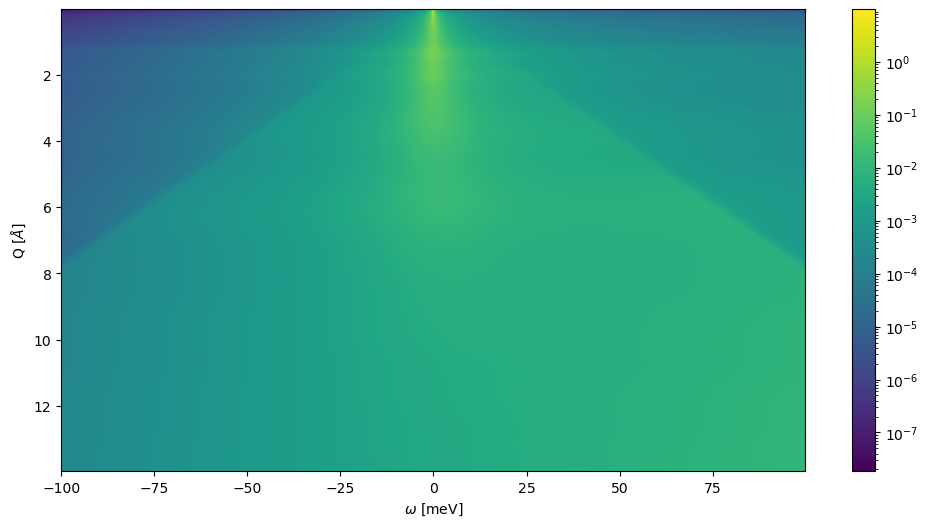

In [576]:
# Useful object for plots
S_imshow_extent = [omega_vec.min(),omega_vec.max(),Q_vec.max(),Q_vec.min()]

# plot
plt.figure(figsize=(12,6))
plt.imshow(S_mesh, norm='log', cmap='viridis', aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

# Initial calculations

## Dynamc range for direct scattering event
The $\theta$-Q relations are:

$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)} \hspace{1cm} cos(\theta) = \frac{k_i^2(2-\frac{\omega}{E_i})-Q^2}{2k_i^2\sqrt{2-\frac{\omega}{E_i}}}
$$
$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)} \hspace{1cm} \text{at} \hspace{1cm} cos\theta=1 \text{   } (\theta=0) \hspace{1cm} cos\theta=-1 \text{   } (\theta=180)
$$

<code>theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))</code>

<code>Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))</code>

/tmp/ipykernel_25764/506250941.py:11: RuntimeWarning: invalid value encountered in arccos
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))


Text(0.5, 0, 'Q')

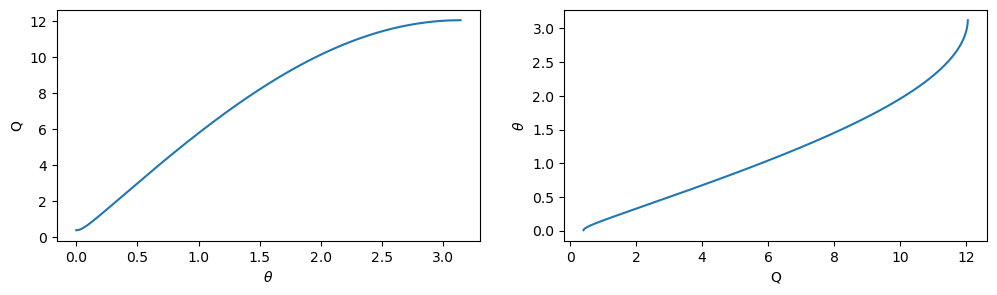

In [577]:
# plot
OMEGA = 10

X = np.linspace(0, np.pi, 1000)
Y = theta2Q(OMEGA, ki, X)

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(X,Y)
plt.xlabel(r'$\theta$')
plt.ylabel('Q')

X = np.linspace(0, 20, 10000)
Y = Q2theta(OMEGA, ki, X)

plt.subplot(1,2,2)
plt.plot(X,Y)
plt.ylabel(r'$\theta$')
plt.xlabel('Q')

In [578]:
###############################################
##### Dynamic range for direct scattering #####
###############################################

dtheta_min = 0.01
theta_max = np.pi-dtheta_min

Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_min))
Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_max))

In [579]:
print('theta_min = ', np.rad2deg(theta_min))
print('theta_max = ', np.rad2deg(theta_max))

theta_min =  0.5729577951308232
theta_max =  179.4270422048692


/tmp/ipykernel_25764/2290679911.py:8: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_min))
/tmp/ipykernel_25764/2290679911.py:9: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_max))


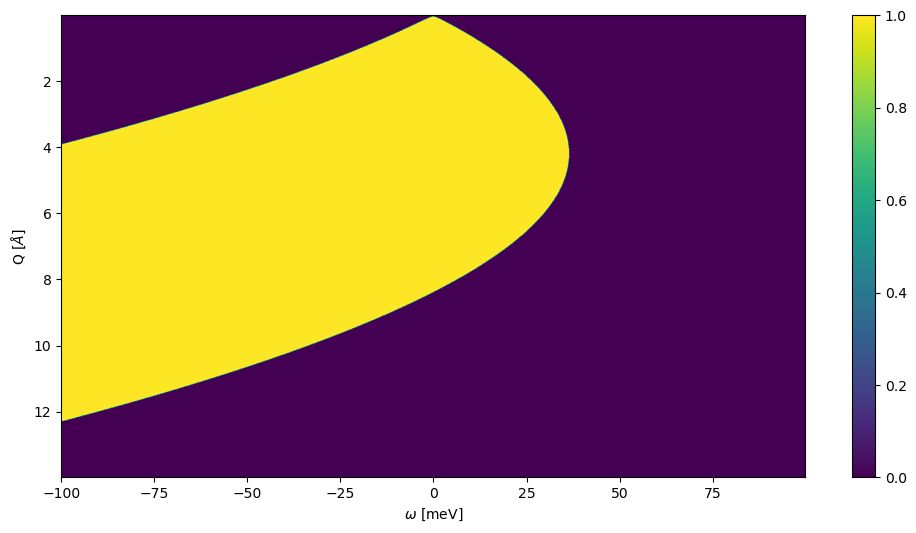

In [580]:
# usage example
k = 4.2 # chose the k value
out = (Q_mesh>Q_lowlim(k)) & (Q_mesh<Q_uplim(k))

# plot
plt.figure(figsize=(12,6))
plt.imshow(out, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();

## Cut of S(Q, $\omega$) for $k_i$ and normalization

In [581]:
####################################
##### Cut of the S(Q,w) for Ei #####
####################################

Mask_Ei = ((Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki)))

S_mesh_cutEi = Mask_Ei * S_mesh

/tmp/ipykernel_25764/2290679911.py:8: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_min))
/tmp/ipykernel_25764/2290679911.py:9: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_max))


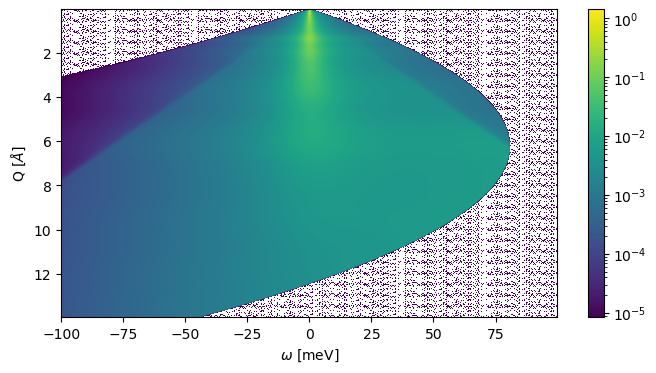

In [582]:
# plot
plt.figure(figsize=(8,4))
plt.imshow(S_mesh_cutEi, aspect='auto', norm='log', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();

## $d\theta$-dQ relation
$$
cos(\theta) = \frac{k_i^2(2-\frac{\omega}{E_i})-Q^2}{2k_i^2\sqrt{1-\frac{\omega}{E_i}}} = \frac{a-Q^2}{b}
$$
$$ a = k_i^2(2-\omega/E_i) \hspace{2cm} b=2k_i^2\sqrt{1-\omega/E_i}$$
$$ \Rightarrow \frac{d\theta}{dQ} = \frac{2Q}{b \sqrt{1-(a-Q^2)^2/b^2}}

<code>def dthetadq(omega, ki, Q):
    a = ki**2*(2-omega/k2E(ki))
    b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
    return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2)) </code>

In [583]:
################################
##### dthetadQ on the mesh #####
################################
dthetadq_pdfEi = np.nan_to_num(dthetadq(omega_mesh, ki, Q_mesh)) * Mask_Ei

/tmp/ipykernel_25764/506250941.py:21: RuntimeWarning: invalid value encountered in sqrt
  b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
/tmp/ipykernel_25764/506250941.py:22: RuntimeWarning: invalid value encountered in sqrt
  return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))


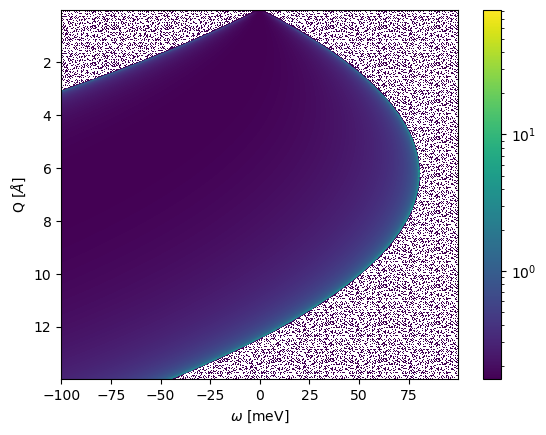

In [584]:
# plot
plt.imshow(dthetadq_pdfEi, aspect='auto', extent=S_imshow_extent, norm='log')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

/tmp/ipykernel_25764/506250941.py:22: RuntimeWarning: invalid value encountered in divide
  return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))
/tmp/ipykernel_25764/506250941.py:22: RuntimeWarning: invalid value encountered in sqrt
  return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))


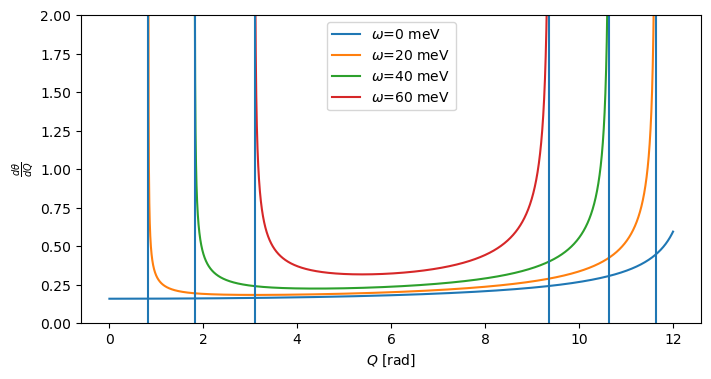

In [585]:
# plot
X = np.linspace(0, 12, 10000)

plt.figure(figsize=(8,4))
plt.plot(X, dthetadq(0, ki, X), label='$\omega$=0 meV')
plt.plot(X, dthetadq(20, ki, X), label='$\omega$=20 meV')
plt.axvline(theta2Q(20, ki, 0))
plt.axvline(theta2Q(20, ki, np.pi))
plt.plot(X, dthetadq(40, ki, X), label='$\omega$=40 meV')
plt.axvline(theta2Q(40, ki, 0))
plt.axvline(theta2Q(40, ki, np.pi))
plt.plot(X, dthetadq(60, ki, X), label='$\omega$=60 meV')
plt.axvline(theta2Q(60, ki, 0))
plt.axvline(theta2Q(60, ki, np.pi))

plt.ylim(0,2)

plt.xlabel(r'$Q$ [rad]')
plt.ylabel(r'$\frac{d\theta}{dQ}$')
plt.legend();

## $\frac{d\theta}{dQ}$ for PDF normalization from the mash
Normalization of the PDF on the mash is done using:
$$ P(\theta\pm dQ_{vec}/2,\omega) = S(Q(\theta),\omega) d\omega d\theta = S(Q(\theta),\omega) d\omega \frac{d\theta}{dQ} dQ_{vec} $$

In [586]:
################################
##### S(Q,w) normalization #####
################################

# NORMALIZATION
PDF_Ei = (S_mesh_cutEi / (S_mesh_cutEi * domega * dthetadq_pdfEi * dQ_vec).sum())

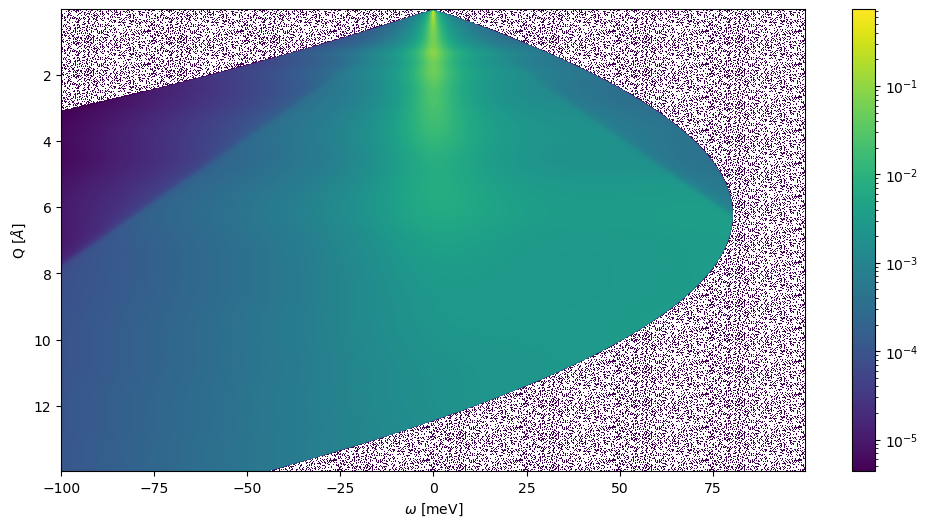

In [587]:
# plot
plt.figure(figsize=(12,6))
plt.imshow(PDF_Ei, aspect='auto', extent=S_imshow_extent, norm='log')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## Lamber-Beer law

The probability of having a scattering event is
$$
(1-T_{s+abs}) - (1-T_{abs}) = T_{abs}-T_{s+abs} = T_{abs}(1-T_s)
$$

In [588]:
###########################
##### Lamber-Beer law #####
###########################

# Trasmission
T_s = lambda d: np.exp(-mu_s*d)
T_abs = lambda d: np.exp(-mu_abs*d)

# Random scattering extraction from Lamber-Beer law
rand_LB = lambda b: truncexpon.rvs(b = b*mu_s)/mu_s

# The simulation

## Randomly generate N neutrons at x=-x_init, random z = [-h/2, h/2] and y[-r, r]

In [589]:
##########################
##### THE SIMULATION #####
##########################

##### RANDOMLY GENERATE N NEUTRONS #####
# from uniform beam at x=-x_init, random z = [-h/2, h/2] and y[-r, r]

p0 = ngen(N)
k0 = np.array([[ki, 0, 0]]*N)
w0 = np.array([1]*N)

Text(0.5, 0, 'z0 [cm]')

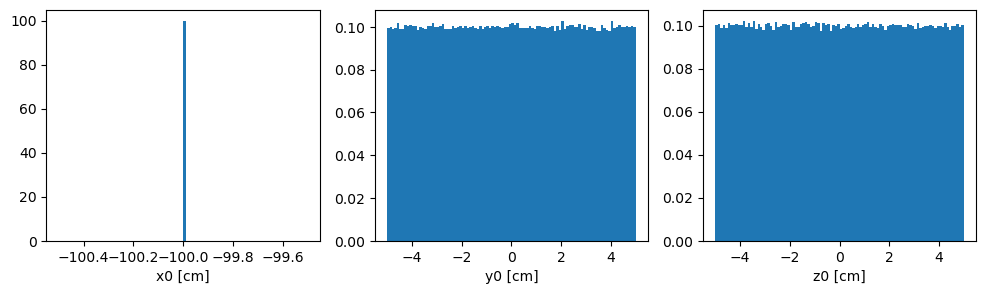

In [590]:
# plots
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(p0[:,0], bins=100, density=True);
plt.xlabel('x0 [cm]')
plt.subplot(1,3,2)
plt.hist(p0[:,1], bins=100, density=True);
plt.xlabel('y0 [cm]')
plt.subplot(1,3,3)
plt.hist(p0[:,2], bins=100, density=True);
plt.xlabel('z0 [cm]')

In [591]:
# dimensions of the vectors
print('p0:', p0.nbytes/1e6, 'MB')
print('k0:', k0.nbytes/1e6, 'MB')
print('w0:', w0.nbytes/1e6, 'MB')

p0: 24.0 MB
k0: 24.0 MB
w0: 8.0 MB


## Extract the scattering positions

In [592]:
##### EXTRACT THE 1ST SCATTERING POSITION #####

# intercept calculation
ts = inter_fromout(p0, k0)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.append(ts, np.zeros((N,2)), axis=1)
if geom_type=='concave':
    pass

d1 = (ts[:,1] - ts[:,0]) + (ts[:,3] - ts[:,2])

# weigth update
w1 = w0*(1-T_s(d1))*T_abs(d1)

# dtp2 extraction (one for all)
dtp2 = rand_LB(d1)

# generate void vector
void = np.where(dtp2<=(ts[:, 1]-ts[:, 0]), 0, ts[:,2] - ts[:,1])

p1 = line_param(ts[:,0] + dtp2 + void, p0, k0)

Text(0, 0.5, 'z [cm]')

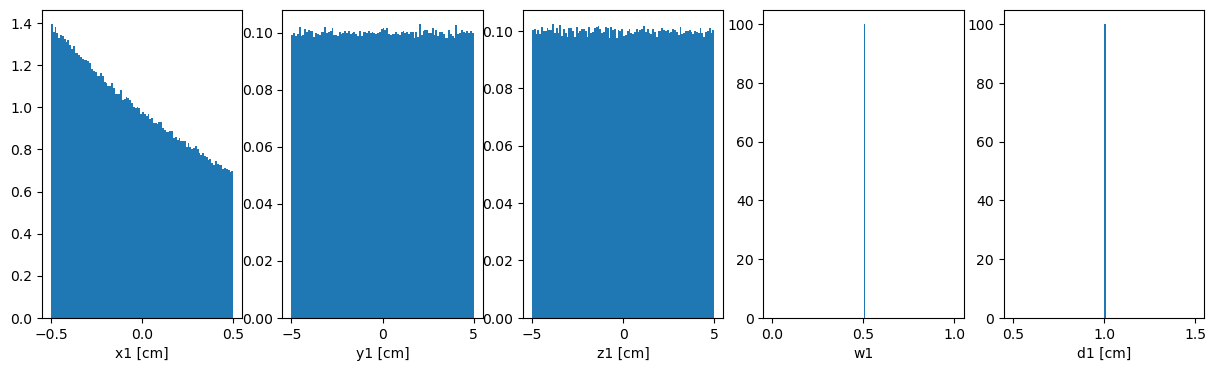

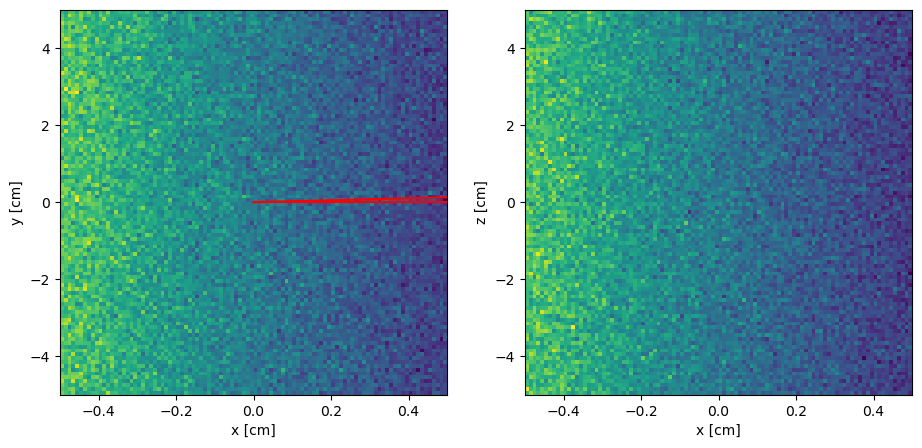

In [593]:
# plots
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.hist(p1[:,0], bins=100, density=True);
plt.xlabel('x1 [cm]')
plt.subplot(1,5,2)
plt.hist(p1[:,1], bins=100, density=True);
plt.xlabel('y1 [cm]')
plt.subplot(1,5,3)
plt.hist(p1[:,2], bins=100, density=True);
plt.xlabel('z1 [cm]')
plt.subplot(1,5,4)
plt.hist(w1, bins=100, density=True);
plt.xlabel('w1')
plt.subplot(1,5,5)
plt.hist(d1, bins=100, density=True);
plt.xlabel('d1 [cm]')

# heatmap
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p1[:,0], p1[:,1], bins=100, weights=w1);

X = np.linspace(0, p1[:,0].max(), 100)
plt.plot(X, X*np.sin(theta), c='r')
plt.plot(X, X*np.sin(0), c='r')

plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,2,2)
plt.hist2d(p1[:,0], p1[:,2], bins=100, weights=w1);
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')

## Probability of single scattering

### Find k1 and omega1 imposing collimator angle

In [594]:
### PROBABILITY OF SINGLE SCATTERING ###

# Find k1, omega1, Q1 imposing collimator angle
k1s = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
Q1s = np.linalg.norm(k0 - k1s, axis=1)
omega1s = (Ei - Ef) * np.ones(N)
theta1s = theta

### Scattering probability from the PDF

Normalization of the PDF on the mash is done using:
$$ P(\theta,\omega) = S(Q(\theta),\omega) d\omega d\theta $$

In [595]:
# Get the scattering probavilities from S_mesh_cutEi (w1s)
Q_idx = np.searchsorted(Q_vec, Q1s)
omega_idx = np.searchsorted(omega_vec, omega1s)

w1s = w1 * PDF_Ei[Q_idx, omega_idx] * domega * dtheta

### Single scattering intercept and trasmission


In [596]:
# intercept calculation
ts = inter_fromin(p1, k1s)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2s = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
wfs = w1s*T_s(d2s)*T_abs(d2s)

/tmp/ipykernel_25764/506250941.py:94: RuntimeWarning: divide by zero encountered in divide
  tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)


## Multiple scattering path

### Extraction from the S(Q, omega)

$$ P(\theta,\omega) = S(Q(\theta),\omega) d\omega d\theta = S(Q(\theta),\omega) d\omega \frac{d\theta}{dQ} dQ_{vec} $$

In [597]:
####################################
##### MULTIPLE SCATTERING PATH #####
####################################

### EXTRACTION FROM S(q,W) ###

# Probaility mesh for random choiches
PDF = S_mesh_cutEi * dthetadq_pdfEi # * dQ_vec * domega
PDF /= PDF.sum()

In [598]:
# Random extractions
is_mesh = np.random.choice(np.arange(PDF.size), p=PDF.reshape(-1), size=N)

# Extracted scattering variables
Q1m = Q_mesh.reshape(-1)[is_mesh]
omega1m = omega_mesh.reshape(-1)[is_mesh]
theta1m = Q2theta(omega1m, ki, Q1m)
E1m = Ei - omega1m
w1m = w1

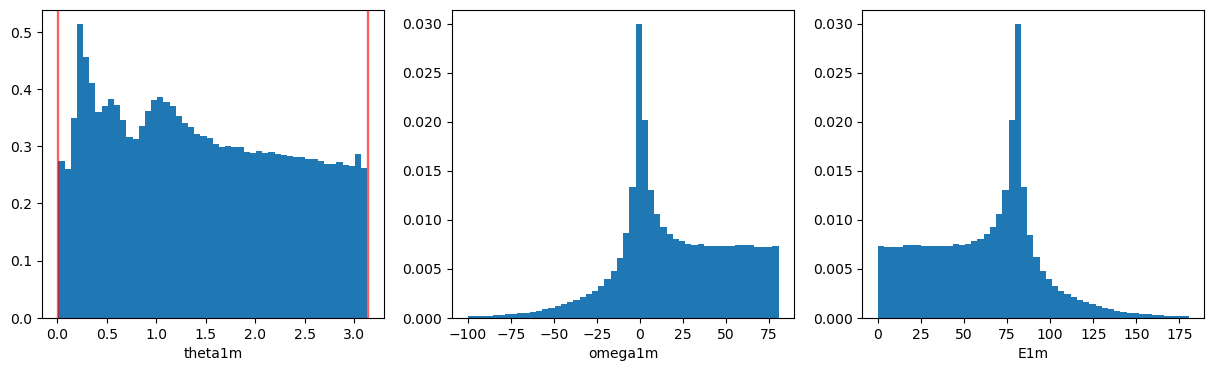

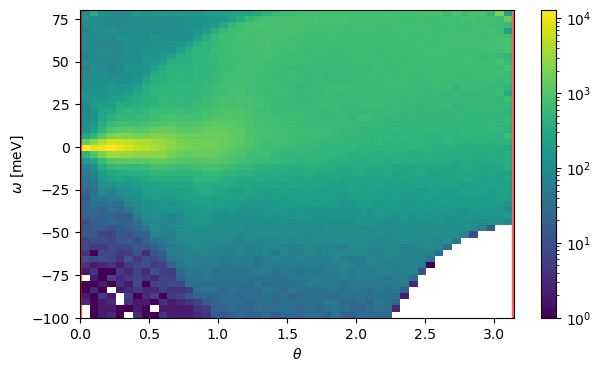

In [614]:
# plot
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(theta1m, bins=50, density=True);
plt.axvspan(0, dtheta_min, alpha=0.5, color='red')
plt.axvspan(np.pi-dtheta_min, np.pi, alpha=0.5, color='red')
plt.xlabel('theta1m')
plt.subplot(1,3,2)
plt.hist(omega1m, bins=50, density=True);
plt.xlabel('omega1m')
plt.subplot(1,3,3)
plt.hist(E1m, bins=50, density=True);
plt.xlabel('E1m')

# 3D
plt.figure(figsize=(7,4))
plt.hist2d(theta1m, omega1m, bins=50, norm='log');
plt.ylabel('$\omega$ [meV]')
plt.xlabel(r'$\theta$')
plt.colorbar()
plt.xlim(0, np.pi)

plt.axvspan(0, dtheta_min, alpha=0.5, color='red')
plt.axvspan(np.pi-dtheta_min, np.pi, alpha=0.5, color='red')

### Creation of the scattering vector

In [600]:
### NEW NEUTRON MOMENTA ###

# Random angle on the scattering cone
phi1m = rand(N)*2*np.pi

In [601]:
# Neutrom momenta after scattering
k1m = (np.array((np.cos(theta1m), np.sin(theta1m)*np.cos(phi1m), np.sin(theta1m)*np.sin(phi1m))) * E2k(E1m)).T
k1m_mod = E2k(E1m)

Text(0, 0.5, 'z [cm]')

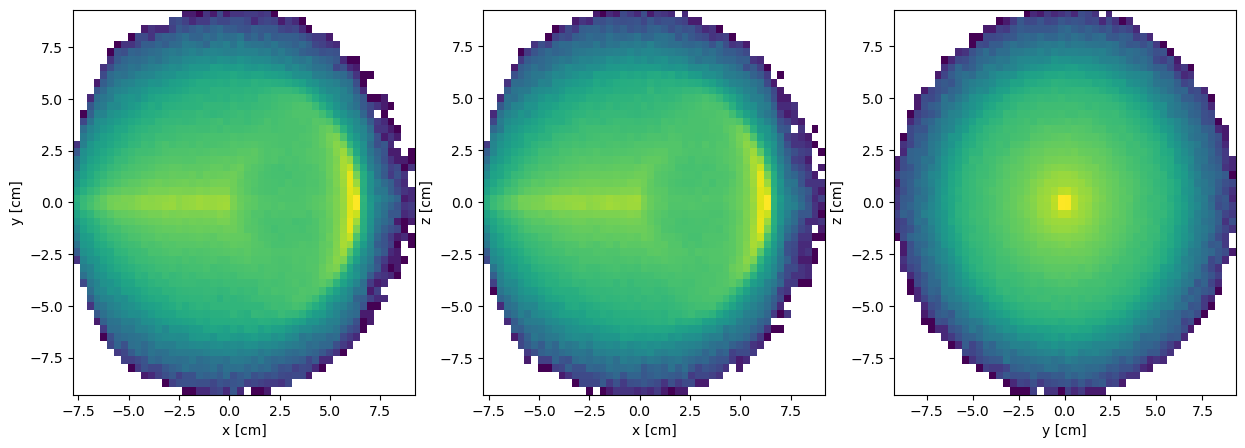

In [602]:
# plot
# heatmap
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(k1m[:,0], k1m[:,1], bins=50, norm='log');
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,3,2)
plt.hist2d(k1m[:,0], k1m[:,2], bins=50, norm='log' );
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.subplot(1,3,3)
plt.hist2d(k1m[:,1], k1m[:,2], bins=50, norm='log');
plt.xlabel('y [cm]')
plt.ylabel('z [cm]')

### Extract a new scattering position for multiple

In [603]:
# intercept calculation
ts = inter_fromin(p1, k1m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2m = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
w2 = w1m*(1-T_s(d2m))*T_abs(d2m)

# dtp2 extraction (one for all)
dtp2 = rand_LB(d2m)

# generate void vector
void = np.where(dtp2<=ts[:, 0], 0,ts[:,1] - ts[:,0])

p2 = line_param(dtp2 + void, p1, k1m)

Text(0, 0.5, 'z [cm]')

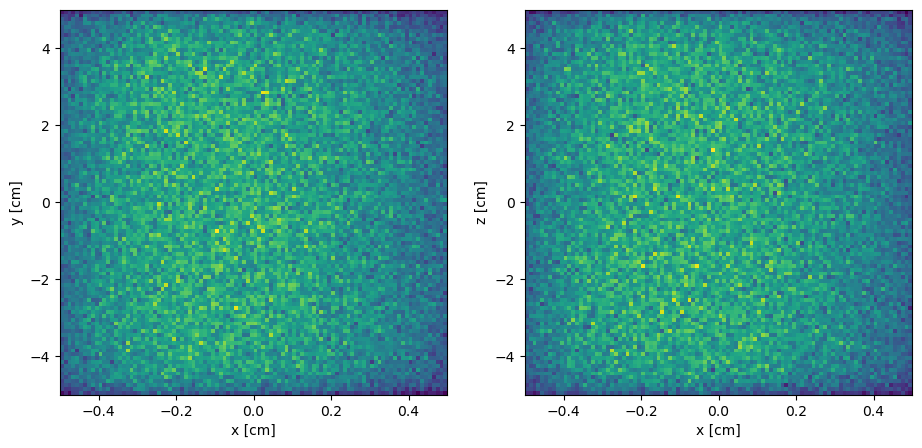

In [604]:
# plot
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p2[:,0], p2[:,1], bins=100, weights=w2);
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(1,2,2)
plt.hist2d(p2[:,0], p2[:,2], bins=100, weights=w2);
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')

### Find k2 and omega2 imposing collimator angle

In [605]:
### Find k2m, omega2m, Q2m imposing collimator angle ###
k2m = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
omega2m = (E1m - Ef) * np.ones(N)
Q2m = np.linalg.norm(k1m - k2m, axis=1)

theta2m = Q2theta(omega2m, E2k(E1m), Q2m)

In [606]:
### Mask of impossible events
mask2m = ~((Q2m>Q_vec.max()) | (Q2m<Q_vec.min()) | (omega2m>omega_vec.max()) | (omega2m<omega_vec.min()) | np.isnan(theta2m))

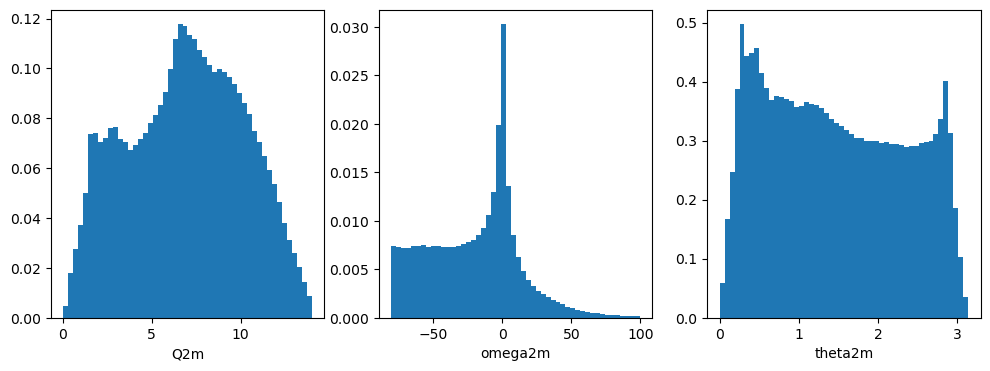

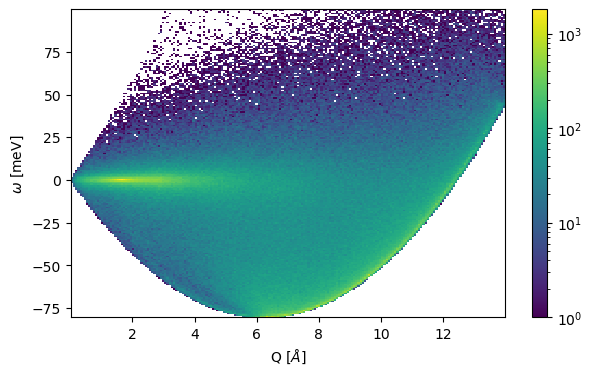

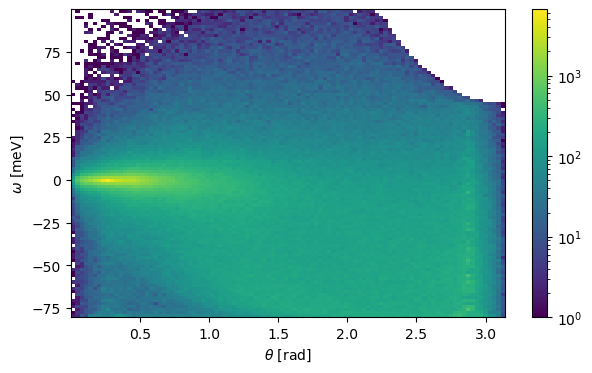

In [607]:
#plot
# 2D
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Q2m[mask2m], bins=50, density=True);
plt.xlabel('Q2m')
plt.subplot(1,3,2)
plt.hist(omega2m[mask2m], bins=50, density=True);
plt.xlabel('omega2m')
plt.subplot(1,3,3)
plt.hist(theta2m[mask2m], bins=50, density=True);
plt.xlabel('theta2m')

plt.figure(figsize=(7,4))
plt.hist2d(Q2m[mask2m], omega2m[mask2m], bins=200, norm=colors.LogNorm());
plt.ylabel('$\omega$ [meV]')
plt.xlabel('Q [$\AA$]')
plt.colorbar()

plt.figure(figsize=(7,4))
plt.hist2d(theta2m[mask2m], omega2m[mask2m], bins=100, norm=colors.LogNorm());
plt.ylabel('$\omega$ [meV]')
plt.xlabel(r'$\theta$ [rad]')
plt.colorbar()

### Scattering probability from the PDF

### Bunching the cuts in S(Q,W) for speed up

In [608]:
### SCATTERING PROBABILITIES FROM THE PDF $$$

# Bunching the initial energies E1m
E_min = E1m[mask2m].min()
E_max = E1m[mask2m].max()
bunch = np.linspace(E_min, E_max, N_bunch)[1:]
dbunch = (bunch[1]-bunch[0])

# find the bunch indexes
bunch_idx = np.searchsorted(bunch, E1m, side='left')
bunch_idx[~mask2m] = -1 # putting impossible events with idx=-1, i.e. in the next part P stay 0

In [609]:
# indexing Q2m and omega2m on the mesh
Q_idx = np.searchsorted(Q_vec, Q2m)
omega_idx = np.searchsorted(omega_vec, omega2m)

In [610]:
# calculating probabilities at bunches
P = np.zeros(N)

for b in range(N_bunch-1):
    # Mask
    Mask = ((Q_mesh>Q_lowlim(E2k(bunch[b]-dbunch/2))) & (Q_mesh<Q_uplim(E2k(bunch[b]-dbunch/2))))
    # S cut
    S_mesh_cut = Mask * S_mesh
    # dthetadQ on the mesh
    dthetadq_pdf = np.nan_to_num(dthetadq(omega_mesh, E2k(bunch[b]-dbunch/2), Q_mesh)) * Mask
    # normalization
    S_mesh_cut /= (S_mesh_cut * domega * dthetadq_pdf * dQ_vec).sum()

    P[bunch_idx==b] = S_mesh_cut[Q_idx[bunch_idx==b], omega_idx[bunch_idx==b]] * domega * dtheta
    
# updating the weights
w2m = w2 * P

/tmp/ipykernel_25764/2290679911.py:8: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_min))
/tmp/ipykernel_25764/2290679911.py:9: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(theta_max))
/tmp/ipykernel_25764/506250941.py:21: RuntimeWarning: invalid value encountered in sqrt
  b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
/tmp/ipykernel_25764/506250941.py:22: RuntimeWarning: invalid value encountered in sqrt
  return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))


### Trasmission of multiple event to the detector

In [611]:
# intercept calculation
ts = inter_fromin(p1, k2m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d3m = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
wfm = w2m*T_s(d3m)*T_abs(d3m)

/tmp/ipykernel_25764/506250941.py:94: RuntimeWarning: divide by zero encountered in divide
  tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)


## Final results

In [612]:
Is = wfs.mean()
Im = wfm.mean()

print('Is:', Is, 'Im:', Im)
print('Im/Is = ', Im/Is)

Is: 1.8301174552711e-05 Im: 6.412208379626539e-07
Im/Is =  0.03503714125647024


## Data analysis


Text(0.5, 0, 'Q')

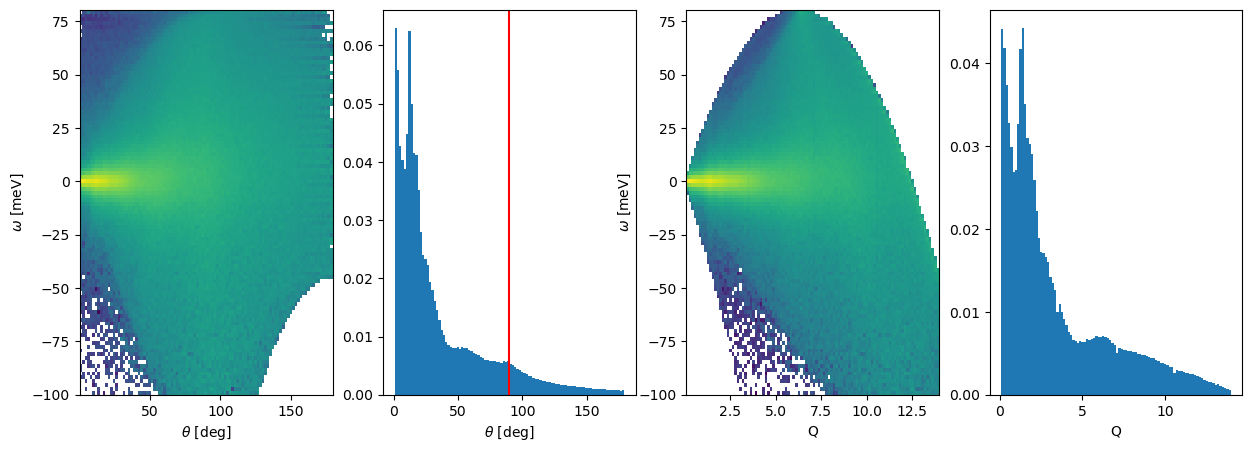

In [613]:
# heatmap
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=100, weights=wfm, norm=colors.LogNorm());
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('$\omega$ [meV]')

plt.subplot(1,4,2)
plt.hist(np.rad2deg(theta1m), bins=100, weights=w2m);
plt.axvline(90, c='r')
plt.xlabel(r'$\theta$ [deg]')

plt.subplot(1,4,3)
plt.hist2d(Q1m, omega1m, bins=100, weights=wfm, norm=colors.LogNorm());
plt.xlabel(r'Q')
plt.ylabel('$\omega$ [meV]')

plt.subplot(1,4,4)
plt.hist(Q1m, bins=100, weights=w2m);
plt.xlabel(r'Q')